# Importing libraries and classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tabulate import tabulate
from sklearn.metrics import median_absolute_error, max_error, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from Utils import Utils

from DecisionTreeRegressor import DecisionTreeRegressor
from RandomForestRegressor import RandomForestRegressor
from LinearRegression import LinearRegression

# Reading and splitting the data

In [2]:
df = pd.read_csv('./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv')

feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate','Average_Population']
X = pd.get_dummies(df[feature_cols], columns=['District', 'Sex'])
y = df["Population"]

NUM_OF_RUNS = 100
NUM_CORES = 4

# Custom Implementations - Decision Tree, Random Forest, Linear Regression

In [3]:
# Decision Trees Hyperparameter tuning & cross validation
DT_Parameters = {
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20],
    'max_depth': [10, 25, 50, 75, 100, 125, 150, 175, 200]
}

DT_All_Best_Predictions = []
DT_Total_Time = 0.0
DT_Total_MSE = 0.0
DT_Total_MAE = 0.0
DT_Total_RMSE = 0.0
DT_Total_R2 = 0.0
DT_Total_Explained_Variance = 0.0
DT_Total_MedianAE = 0.0
DT_Total_MaxError = 0.0

for run in range(NUM_OF_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run)

    DT_Best_Model = None
    DT_Best_Prediction = None
    DT_Best_Parameters = None
    DT_Best_Time = None
    DT_Best_MSE = float('inf')

    for min_samples_split in DT_Parameters['min_samples_split']:
        for max_depth in DT_Parameters['max_depth']:
            DT_Start_Time = time.time()
            DT_Temp_Model = DecisionTreeRegressor(min_samples_split=min_samples_split, max_depth=max_depth)
            DT_Temp_Model.fit(X_train.values, y_train.values)
            DT_Temp_Prediction = DT_Temp_Model.predict(X_test.values)
            DT_End_Time = time.time()
            DT_Temp_Time = DT_End_Time - DT_Start_Time
            DT_Temp_MSE = mean_squared_error(y_test, DT_Temp_Prediction)

            # Determining best hyperparameters based on MSE
            if DT_Temp_MSE < DT_Best_MSE:
                DT_Best_Model = DT_Temp_Model
                DT_Best_Parameters = {'min_samples_split': min_samples_split, 'max_depth': max_depth}
                DT_Best_Prediction = DT_Temp_Prediction
                DT_Best_Time = DT_Temp_Time
                DT_Best_MSE = DT_Temp_MSE

    # Storing values to find average after all runs finished
    DT_All_Best_Predictions.append(DT_Best_Prediction)
    DT_Total_Time = DT_Total_Time + DT_Best_Time
    DT_Total_MSE = DT_Total_MSE + DT_Best_MSE
    DT_Total_MAE = DT_Total_MAE + mean_absolute_error(y_test, DT_Best_Prediction)  # Mean Absolute Error
    DT_Total_RMSE = DT_Total_RMSE + Utils.root_mean_squared_error(y_test, DT_Best_Prediction)  # Root Mean Squared Error
    DT_Total_R2 = DT_Total_R2 + r2_score(y_test, DT_Best_Prediction)  # R-squared
    DT_Total_Explained_Variance = DT_Total_Explained_Variance + explained_variance_score(y_test, DT_Best_Prediction)  # Explained Variance Score
    DT_Total_MedianAE = DT_Total_MedianAE + median_absolute_error(y_test, DT_Best_Prediction)  # Median Absolute Error
    DT_Total_MaxError = max_error(y_test, DT_Best_Prediction)  # Maximum Error

    print(f"Run {run + 1}")

# Here we need to find the average evaluation values across all runs
DT_Average_Predictions = np.mean(DT_All_Best_Predictions, axis=0)
DT_Average_Time = DT_Total_Time / NUM_OF_RUNS
DT_Average_MSE = DT_Total_MSE / NUM_OF_RUNS
DT_Average_MAE = DT_Total_MAE / NUM_OF_RUNS
DT_Average_RMSE = DT_Total_RMSE / NUM_OF_RUNS
DT_Average_R2 = DT_Total_R2 / NUM_OF_RUNS
DT_Average_Explained_Variance = DT_Total_Explained_Variance / NUM_OF_RUNS
DT_Average_MedianAE = DT_Total_MedianAE / NUM_OF_RUNS
DT_Average_MaxError = DT_Total_MaxError / NUM_OF_RUNS

print(f"\nDecision Tree Metrics over {NUM_OF_RUNS} runs:")
print(f"Average Time to run in seconds: {DT_Average_Time:.6f}")
print(f"Average Mean Squared Error: {DT_Average_MSE:.6f}")
print(f"Average Root Mean Squared Error: {DT_Average_RMSE:.6f}")
print(f"Average Mean Absolute Error: {DT_Average_MAE:.6f}")
print(f"Average R Squared: {DT_Average_R2:.6f}")
print(f"Average Explained Variance: {DT_Average_Explained_Variance:.6f}")
print(f"Average Median Absolute Error: {DT_Average_MedianAE:.6f}")
print(f"Average Max Error: {DT_Average_MaxError:.6f}")

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Run 50
Run 51
Run 52
Run 53
Run 54
Run 55
Run 56
Run 57
Run 58
Run 59
Run 60
Run 61
Run 62
Run 63
Run 64
Run 65
Run 66
Run 67
Run 68
Run 69
Run 70
Run 71
Run 72
Run 73
Run 74
Run 75
Run 76
Run 77
Run 78
Run 79
Run 80
Run 81
Run 82
Run 83
Run 84
Run 85
Run 86
Run 87
Run 88
Run 89
Run 90
Run 91
Run 92
Run 93
Run 94
Run 95
Run 96
Run 97
Run 98
Run 99
Run 100

Decision Tree Metrics over 100 runs:
Average Time to run in seconds: 0.098601
Average Mean Squared Error: 0.000431
Average Root Mean Squared Error: 0.019552
Average Mean Absolute Error: 0.010850
Average R Squared: 0.990773
Average Explained Variance: 0.991127
Average Median Absolute Error: 0.004376
Average

In [4]:
# Random Forest Hyperparameter Tuning & cross validation
RF_Parameters = {
    'n_estimators': [75, 100, 125],
    'min_samples_split': [2, 5, 10],
    'max_depth': [25, 50, 75, 100]
}

RF_All_Best_Predictions = []
RF_Total_Time = 0.0
RF_Total_MSE = 0.0
RF_Total_MAE = 0.0
RF_Total_RMSE = 0.0
RF_Total_R2 = 0.0
RF_Total_Explained_Variance = 0.0
RF_Total_MedianAE = 0.0
RF_Total_MaxError = 0.0

for run in range(NUM_OF_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run)

    RF_Best_Model = None
    RF_Best_Prediction = None
    RF_Best_Parameters = None
    RF_Best_Time = None
    RF_Best_MSE = float('inf')

    for n_estimators in RF_Parameters['n_estimators']:
        for min_sample_split in RF_Parameters['min_samples_split']:
            for max_depth in RF_Parameters['max_depth']:
                RF_Start_Time = time.time()
                RF_Temp_Model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_sample_split)
                RF_Temp_Model.fit(X_train, y_train)
                RF_Temp_Prediction = RF_Temp_Model.predict(X_test)
                RF_End_Time = time.time()
                RF_Temp_Time = RF_End_Time - RF_Start_Time
                RF_Temp_MSE = mean_squared_error(y_test, RF_Temp_Prediction)

                # Determining best hyperparameters based on MSE
                if RF_Temp_MSE < RF_Best_MSE:
                    RF_Best_Model = RF_Temp_Model
                    RF_Best_Parameters = {'n_estimators': n_estimators, 'min_samples_split': min_samples_split, 'max_depth': max_depth}
                    RF_Best_Prediction = RF_Temp_Prediction
                    RF_Best_Time = RF_Temp_Time
                    RF_Best_MSE = RF_Temp_MSE

    # Storing values to find average after all runs finished
    RF_All_Best_Predictions.append(RF_Best_Prediction)
    RF_Total_Time = RF_Total_Time + RF_Best_Time
    RF_Total_MSE = RF_Total_MSE + RF_Best_MSE
    RF_Total_MAE = RF_Total_MAE + mean_absolute_error(y_test, RF_Best_Prediction)  # Mean Absolute Error
    RF_Total_RMSE = RF_Total_RMSE + Utils.root_mean_squared_error(y_test, RF_Best_Prediction)  # Root Mean Squared Error
    RF_Total_R2 = RF_Total_R2 + r2_score(y_test, RF_Best_Prediction)  # R-squared
    RF_Total_Explained_Variance = RF_Total_Explained_Variance + explained_variance_score(y_test, RF_Best_Prediction)  # Explained Variance Score
    RF_Total_MedianAE = RF_Total_MedianAE + median_absolute_error(y_test, RF_Best_Prediction)  # Median Absolute Error
    RF_Total_MaxError = max_error(y_test, RF_Best_Prediction)  # Maximum Error

    print(f"Run {run + 1}")

# Here we need to find the average evaluation values across all runs
RF_Average_Predictions = np.mean(RF_All_Best_Predictions, axis=0)
RF_Average_Time = RF_Total_Time / NUM_OF_RUNS
RF_Average_MSE = RF_Total_MSE / NUM_OF_RUNS
RF_Average_MAE = RF_Total_MAE / NUM_OF_RUNS
RF_Average_RMSE = RF_Total_RMSE / NUM_OF_RUNS
RF_Average_R2 = RF_Total_R2 / NUM_OF_RUNS
RF_Average_Explained_Variance = RF_Total_Explained_Variance / NUM_OF_RUNS
RF_Average_MedianAE = RF_Total_MedianAE / NUM_OF_RUNS
RF_Average_MaxError = RF_Total_MaxError / NUM_OF_RUNS

print(f"\nRandom Forest Metrics over {NUM_OF_RUNS} runs:")
print(f"Average Time to run in seconds: {RF_Average_Time:.6f}")
print(f"Average Mean Squared Error: {RF_Average_MSE:.6f}")
print(f"Average Root Mean Squared Error: {RF_Average_RMSE:.6f}")
print(f"Average Mean Absolute Error: {RF_Average_MAE:.6f}")
print(f"Average R Squared: {RF_Average_R2:.6f}")
print(f"Average Explained Variance: {RF_Average_Explained_Variance:.6f}")
print(f"Average Median Absolute Error: {RF_Average_MedianAE:.6f}")
print(f"Average Max Error: {RF_Average_MaxError:.6f}")

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Run 50
Run 51
Run 52
Run 53
Run 54
Run 55
Run 56
Run 57
Run 58
Run 59
Run 60
Run 61
Run 62
Run 63
Run 64
Run 65
Run 66
Run 67
Run 68
Run 69
Run 70
Run 71
Run 72
Run 73
Run 74
Run 75
Run 76
Run 77
Run 78
Run 79
Run 80
Run 81
Run 82
Run 83
Run 84
Run 85
Run 86
Run 87
Run 88
Run 89
Run 90
Run 91
Run 92
Run 93
Run 94
Run 95
Run 96
Run 97
Run 98
Run 99
Run 100

Random Forest Metrics over 100 runs:
Average Time to run in seconds: 14.465152
Average Mean Squared Error: 0.000334
Average Root Mean Squared Error: 0.017144
Average Mean Absolute Error: 0.009855
Average R Squared: 0.993118
Average Explained Variance: 0.993537
Average Median Absolute Error: 0.004803
Averag

In [5]:
# Linear Regression Hyperparameter tuning & cross validation
LR_Parameters = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'num_iterations': [50, 100, 250, 500, 750, 1000, 1250, 1500]
}

LR_All_Best_Predictions = []
LR_Total_Time = 0.0
LR_Total_MSE = 0.0
LR_Total_MAE = 0.0
LR_Total_RMSE = 0.0
LR_Total_R2 = 0.0
LR_Total_Explained_Variance = 0.0
LR_Total_MedianAE = 0.0
LR_Total_MaxError = 0.0

for run in range(NUM_OF_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run)

    LR_Best_Model = None
    LR_Best_Prediction = None
    LR_Best_Parameters = None
    LR_Best_Time = None
    LR_Best_MSE = float('inf')

    for learning_rate in LR_Parameters['learning_rate']:
        for num_iterations in LR_Parameters['num_iterations']:
            LR_Start_Time = time.time()
            LR_Temp_Model = LinearRegression(learning_rate=learning_rate, num_iterations=num_iterations)
            LR_Temp_Model.fit(X_train.values, y_train.values)
            LR_Temp_Prediction = LR_Temp_Model.predict(X_test.values)
            LR_End_Time = time.time()
            LR_Temp_Time = LR_End_Time - LR_Start_Time
            LR_Temp_MSE = mean_squared_error(y_test, LR_Temp_Prediction)

            # Determining best hyperparameters based on MSE
            if LR_Temp_MSE < LR_Best_MSE:
                LR_Best_Model = LR_Temp_Model
                LR_Best_Parameters = {'learning_rate': learning_rate, 'num_iterations': num_iterations}
                LR_Best_Prediction = LR_Temp_Prediction
                LR_Best_Time = LR_Temp_Time
                LR_Best_MSE = LR_Temp_MSE

    # Storing values to find average after all runs finished
    LR_All_Best_Predictions.append(RF_Best_Prediction)
    LR_Total_Time = LR_Total_Time + LR_Best_Time
    LR_Total_MSE = LR_Total_MSE + LR_Best_MSE
    LR_Total_MAE = LR_Total_MAE + mean_absolute_error(y_test, LR_Best_Prediction)  # Mean Absolute Error
    LR_Total_RMSE = LR_Total_RMSE + Utils.root_mean_squared_error(y_test, LR_Best_Prediction)  # Root Mean Squared Error
    LR_Total_R2 = LR_Total_R2 + r2_score(y_test, LR_Best_Prediction)  # R-squared
    LR_Total_Explained_Variance = LR_Total_Explained_Variance + explained_variance_score(y_test, LR_Best_Prediction)  # Explained Variance Score
    LR_Total_MedianAE = LR_Total_MedianAE + median_absolute_error(y_test, LR_Best_Prediction)  # Median Absolute Error
    LR_Total_MaxError = max_error(y_test, LR_Best_Prediction)  # Maximum Error

    print(f"Run {run + 1}")

# Here we need to find the average evaluation values across all runs
LR_Average_Predictions = np.mean(LR_All_Best_Predictions, axis=0)
LR_Average_Time = LR_Total_Time / NUM_OF_RUNS
LR_Average_MSE = LR_Total_MSE / NUM_OF_RUNS
LR_Average_MAE = LR_Total_MAE / NUM_OF_RUNS
LR_Average_RMSE = LR_Total_RMSE / NUM_OF_RUNS
LR_Average_R2 = LR_Total_R2 / NUM_OF_RUNS
LR_Average_Explained_Variance = LR_Total_Explained_Variance / NUM_OF_RUNS
LR_Average_MedianAE = LR_Total_MedianAE / NUM_OF_RUNS
LR_Average_MaxError = LR_Total_MaxError / NUM_OF_RUNS

print(f"\nLinear Regression Metrics over {NUM_OF_RUNS} runs:")
print(f"Average Time to run in seconds: {LR_Average_Time:.6f}")
print(f"Average Mean Squared Error: {LR_Average_MSE:.6f}")
print(f"Average Root Mean Squared Error: {LR_Average_RMSE:.6f}")
print(f"Average Mean Absolute Error: {LR_Average_MAE:.6f}")
print(f"Average R Squared: {LR_Average_R2:.6f}")
print(f"Average Explained Variance: {LR_Average_Explained_Variance:.6f}")
print(f"Average Median Absolute Error: {LR_Average_MedianAE:.6f}")
print(f"Average Max Error: {LR_Average_MaxError:.6f}")

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32
Run 33
Run 34
Run 35
Run 36
Run 37
Run 38
Run 39
Run 40
Run 41
Run 42
Run 43
Run 44
Run 45
Run 46
Run 47
Run 48
Run 49
Run 50
Run 51
Run 52
Run 53
Run 54
Run 55
Run 56
Run 57
Run 58
Run 59
Run 60
Run 61
Run 62
Run 63
Run 64
Run 65
Run 66
Run 67
Run 68
Run 69
Run 70
Run 71
Run 72
Run 73
Run 74
Run 75
Run 76
Run 77
Run 78
Run 79
Run 80
Run 81
Run 82
Run 83
Run 84
Run 85
Run 86
Run 87
Run 88
Run 89
Run 90
Run 91
Run 92
Run 93
Run 94
Run 95
Run 96
Run 97
Run 98
Run 99
Run 100

Linear Regression Metrics over 100 runs:
Average Time to run in seconds: 0.120601
Average Mean Squared Error: 0.002307
Average Root Mean Squared Error: 0.046750
Average Mean Absolute Error: 0.033095
Average R Squared: 0.950937
Average Explained Variance: 0.952640
Average Median Absolute Error: 0.025280
Ave

# Scatter Plot - Actual vs Predicted values

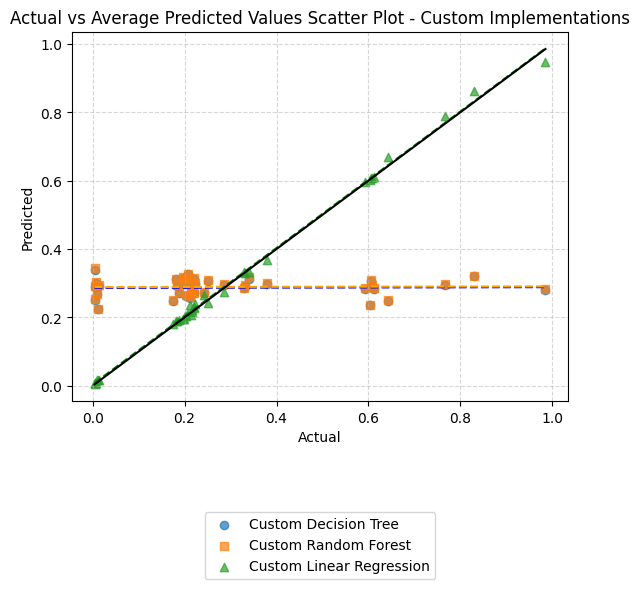

In [6]:
# Custom Decision Tree vs Custom Random Forest vs Custom Linear Regression
y_test_numeric = np.asarray(y_test, dtype=np.float64)
DT_Prediction_Numeric = np.asarray(DT_Average_Predictions, dtype=np.float64)
RF_Prediction_Numeric = np.asarray(RF_Average_Predictions, dtype=np.float64)
LR_Prediction_Numeric = np.asarray(LR_Average_Predictions, dtype=np.float64)

plt.scatter(y_test, DT_Prediction_Numeric, alpha=0.7, marker='o', label='Custom Decision Tree')
plt.scatter(y_test, RF_Prediction_Numeric, alpha=0.7, marker='s', label='Custom Random Forest')
plt.scatter(y_test, LR_Prediction_Numeric, alpha=0.7, marker='^', label='Custom Linear Regression')

# Regression lines
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, DT_Prediction_Numeric, 1))(np.unique(y_test)), color='blue', linestyle='--')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, RF_Prediction_Numeric, 1))(np.unique(y_test)), color='orange', linestyle='--')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, LR_Prediction_Numeric, 1))(np.unique(y_test)), color='green', linestyle='--')

# Reference line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color='black')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Average Predicted Values Scatter Plot - Custom Implementations')

plt.legend(['Custom Decision Tree', 'Custom Random Forest', 'Custom Linear Regression'], loc='lower center', bbox_to_anchor=(0.5,-0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Line Plot - Actual vs Predicted values

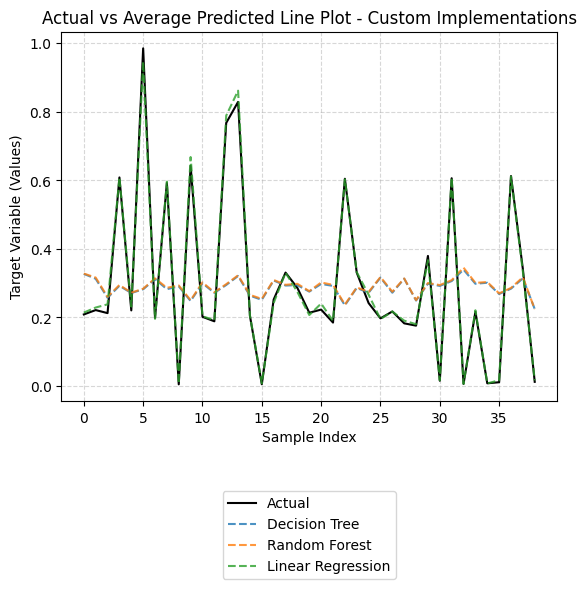

In [7]:
# Custom Decision Tree vs Custom Random Forest vs Custom Linear Regression
plt.plot(y_test.values, label='Actual', color='black', linestyle='-')
plt.plot(DT_Average_Predictions, label='Decision Tree', alpha=0.8, linestyle='--')
plt.plot(RF_Average_Predictions, label='Random Forest', alpha=0.8, linestyle='--')
plt.plot(LR_Average_Predictions, label='Linear Regression', alpha=0.8, linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (Values)')
plt.title('Actual vs Average Predicted Line Plot - Custom Implementations')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Residual Plots

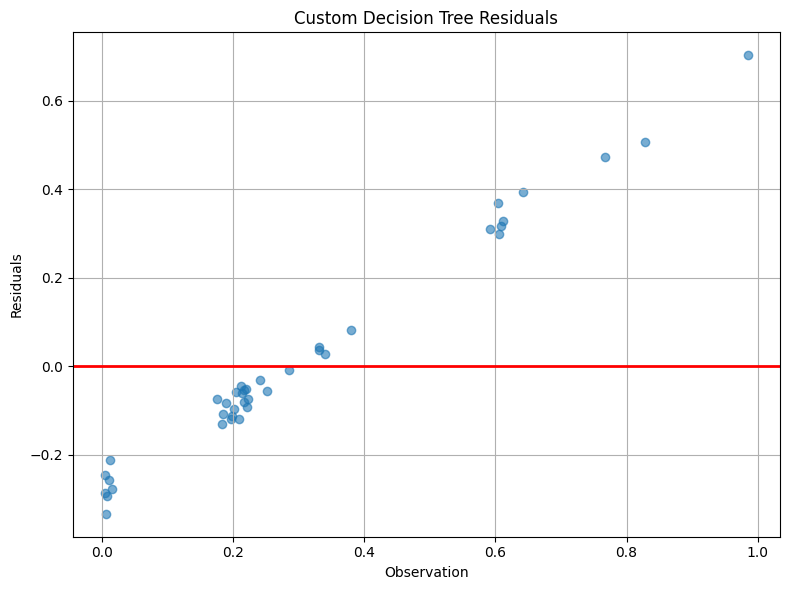

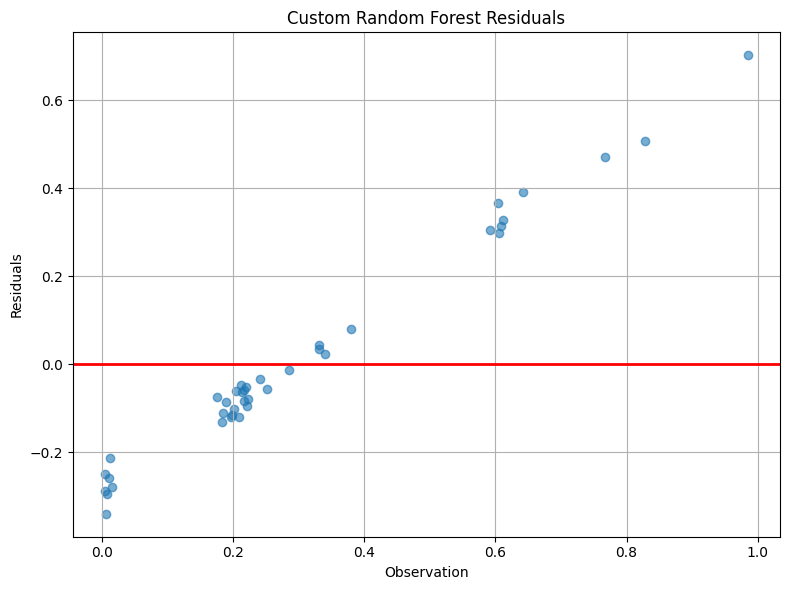

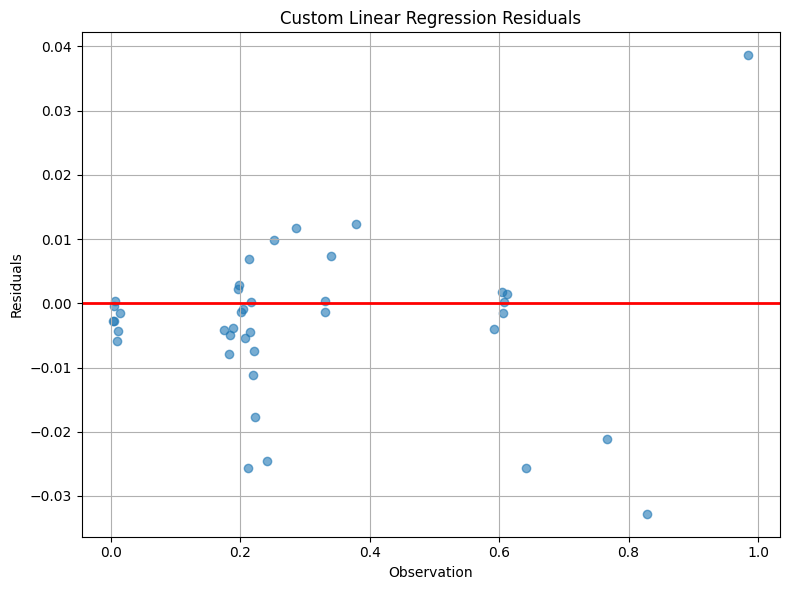

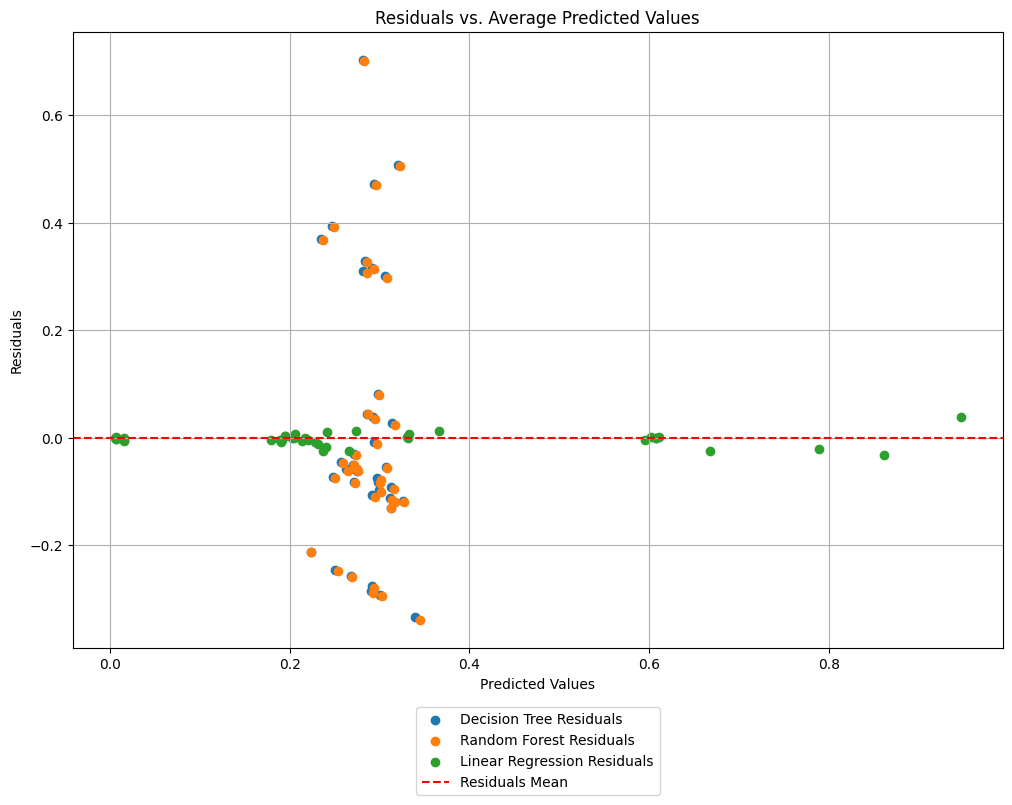

In [8]:
DT_Residuals = y_test - DT_Average_Predictions
RF_Residuals = y_test - RF_Average_Predictions
LR_Residuals = y_test - LR_Average_Predictions

# Plot for Custom Decision Tree
plt.figure(figsize=(8, 6))
plt.scatter(y_test, DT_Residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.grid(True)
plt.xlabel('Observation')
plt.ylabel('Residuals')
plt.title('Custom Decision Tree Residuals')
plt.tight_layout()
plt.show()

# Plot for Custom Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, RF_Residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.grid(True)
plt.xlabel('Observation')
plt.ylabel('Residuals')
plt.title('Custom Random Forest Residuals')
plt.tight_layout()
plt.show()

# Plot for Custom Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, LR_Residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.grid(True)
plt.xlabel('Observation')
plt.ylabel('Residuals')
plt.title('Custom Linear Regression Residuals')
plt.tight_layout()
plt.show()

# Residuals vs. Predicted Values for all models
plt.figure(figsize=(12, 8))
plt.scatter(DT_Average_Predictions, DT_Residuals, label='Decision Tree Residuals')
plt.scatter(RF_Average_Predictions, RF_Residuals, label='Random Forest Residuals')
plt.scatter(LR_Average_Predictions, LR_Residuals, label='Linear Regression Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Residuals Mean')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Average Predicted Values')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.25))
plt.grid(True)
plt.show()

# Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, R Squared, Cross-Validation, Explained Variance

In [9]:
table_data = {
    '': ['Custom Decision Tree Regressor', 'Custom Random Forest Regressor', 'Custom Linear Regression'],
    'Average Time to run in seconds': [DT_Average_Time, RF_Average_Time, LR_Average_Time],
    'Average Mean Absolute Error': [DT_Average_MAE, RF_Average_MAE, RF_Average_MAE],
    'Average Median Absolute Error': [DT_Average_MedianAE, RF_Average_MedianAE, LR_Average_MedianAE],
    'Average Mean Squared Error': [DT_Average_MSE, RF_Average_MSE, LR_Average_MSE],
    'Average Root Mean Squared Error': [DT_Average_RMSE, RF_Average_RMSE, LR_Average_RMSE],
    'Average R Squared': [DT_Average_R2, RF_Average_R2, LR_Average_R2],
    'Average Explained Variance': [DT_Average_Explained_Variance, RF_Average_Explained_Variance, LR_Average_Explained_Variance],
    'Average Maximum Error': [DT_Average_MaxError, RF_Average_MaxError, LR_Average_MaxError]
}

print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

╒════════════════════════════════╤══════════════════════════════════╤═══════════════════════════════╤═════════════════════════════════╤══════════════════════════════╤═══════════════════════════════════╤═════════════════════╤══════════════════════════════╤═════════════════════════╕
│                                │   Average Time to run in seconds │   Average Mean Absolute Error │   Average Median Absolute Error │   Average Mean Squared Error │   Average Root Mean Squared Error │   Average R Squared │   Average Explained Variance │   Average Maximum Error │
╞════════════════════════════════╪══════════════════════════════════╪═══════════════════════════════╪═════════════════════════════════╪══════════════════════════════╪═══════════════════════════════════╪═════════════════════╪══════════════════════════════╪═════════════════════════╡
│ Custom Decision Tree Regressor │                        0.0986009 │                    0.0108503  │                      0.00437623 │                  0

# Actual vs Predicted Values

╒═════════════════╤═══════════════════════════════╤═══════════════════════════════╤═══════════════════════════════╕
│   Actual Values │   Average DT Predicted Values │   Average RF Predicted Values │   Average LR Predicted Values │
╞═════════════════╪═══════════════════════════════╪═══════════════════════════════╪═══════════════════════════════╡
│      0.20827    │                      0.326665 │                      0.327519 │                    0.213635   │
├─────────────────┼───────────────────────────────┼───────────────────────────────┼───────────────────────────────┤
│      0.220988   │                      0.312379 │                      0.315981 │                    0.228429   │
├─────────────────┼───────────────────────────────┼───────────────────────────────┼───────────────────────────────┤
│      0.212111   │                      0.256764 │                      0.259403 │                    0.23771    │
├─────────────────┼───────────────────────────────┼─────────────────────

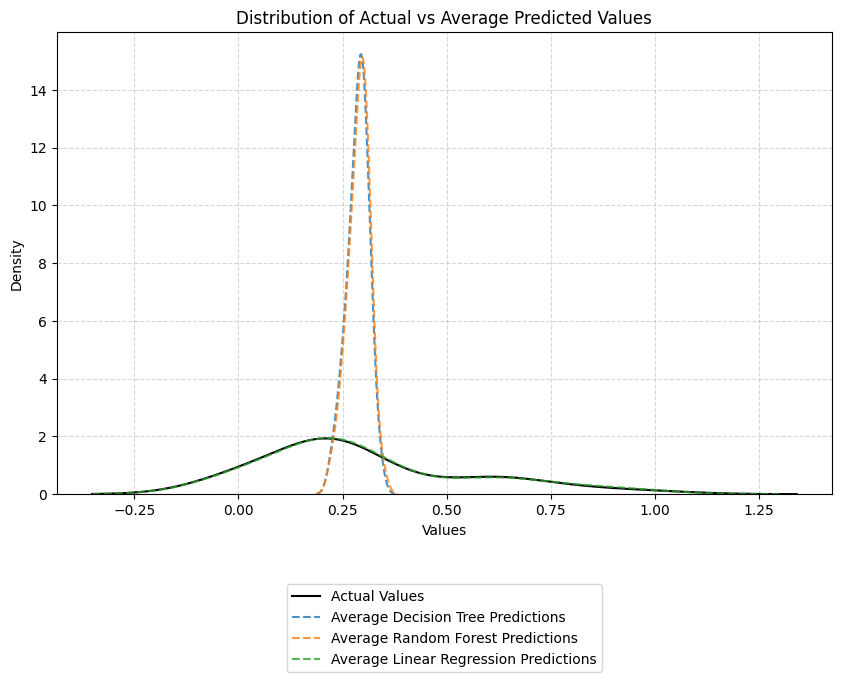

In [10]:
results_table_data = {
    'Actual Values': y_test,
    'Average DT Predicted Values': DT_Average_Predictions,
    'Average RF Predicted Values': RF_Average_Predictions,
    'Average LR Predicted Values': LR_Average_Predictions
}

print(tabulate(results_table_data, headers='keys', tablefmt='fancy_grid'))

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Values', color='black', linestyle='-')
sns.kdeplot(DT_Average_Predictions, label='Average Decision Tree Predictions', alpha=0.8, linestyle='--')
sns.kdeplot(RF_Average_Predictions, label='Average Random Forest Predictions', alpha=0.8, linestyle='--')
sns.kdeplot(LR_Average_Predictions, label='Average Linear Regression Predictions', alpha=0.8, linestyle='--')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Average Predicted Values')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()